In [2]:
import numpy as np
import pandas as pd
import ast 
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
df = pd.read_csv('eval_features.csv')
df.sample(5)

,filename,head_movement,feature_lengths,flicker,blink,lip_movement_variance,ssim,psnr,pulse,fake
9,17.mp4,"[-1.4698872566223145, -1.4698872566223145, 1.1...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8104424476623535, 1.4692541360855103, -0.5...","[0.0, 9.0, 0.0, 3.0, 0.0]","[1.1340230703353882, 0.9698572754859924, 2.0, ...","[0.8074041604995728, -1.7959074974060059, 0.62...","[1.2587264776229858, -1.3687968254089355, 0.11...","[-1.4210854715202004e-14, -1.4210854715202004e...",1
26,27.mp4,"[0.5168889164924622, 0.014869560487568378, -0....","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.8825492262840271, 1.7333590984344482, -0.6...","[0.0, 1.0, 3.0, 3.0, 0.0]","[0.7950463891029358, 0.7133976221084595, 0.421...","[0.8851732015609741, -1.0875537395477295, 0.69...","[0.6681202054023743, -1.0329504013061523, 0.25...","[1.9339033365249634, 1.4241429567337036, 0.598...",0
32,11.mp4,"[-0.03143012896180153, 0.432781845331192, -1.7...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7935228943824768, 1.8584328889846802, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.8043959736824036, 0.9093046188354492, 1.324...","[0.8854838609695435, -1.457051157951355, 1.074...","[0.6680983304977417, -1.2342485189437866, 1.62...","[-0.35128769278526306, -0.5982029438018799, -0...",0
46,30.mp4,"[1.9139891862869263, 1.889148473739624, -0.940...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.7574509978294373, 0.53578782081604, -0.761...","[4.0, 4.0, 8.0, 12.0, 4.0]","[0.7511157393455505, 0.6700252294540405, 0.630...","[0.8263994455337524, -0.757413387298584, 0.830...","[0.8224049210548401, -1.0105839967727661, 0.85...","[-0.5569972991943359, -0.5569972991943359, -0....",0
33,9.mp4,"[-0.33713576197624207, 0.03750252723693848, -1...","[45.0, 5.0, 5.0, 50.0, 50.0, 45.0, 45.0]","[-0.777692973613739, 0.7408161163330078, -0.73...","[1.0, 1.0, 9.0, 10.0, 9.0]","[0.6498268842697144, 0.912499725818634, 0.5387...","[0.7683319449424744, -0.7552745938301086, 0.79...","[0.41768813133239746, -0.5665079951286316, 0.5...","[-0.6646572351455688, -0.5416747331619263, -0....",0


In [5]:
df = df.drop(columns=["filename"])

In [6]:
# Option 1: Concatenate all features (flatten nested lists)

# Convert all columns except 'fake' from string to list
for col in df.columns:
    if col != "fake":
        df[col] = df[col].apply(ast.literal_eval)

# This flattens each row of lists into a single feature vector
X = np.array([np.concatenate(row.values) for _, row in df.drop(columns=["fake"]).iterrows()])
y = df["fake"].values

In [8]:
#option 2: summarize each list with aggregate features (mean, std, etc.)
for col in df.columns:
    if col != "fake":
        df[col] = df[col].apply(ast.literal_eval)

agg_df = df.copy()
for col in df.columns:
    if col != "fake":
        agg_df[f"{col}_mean"] = df[col].apply(np.mean)
        agg_df[f"{col}_std"] = df[col].apply(np.std)
        agg_df[f"{col}_max"] = df[col].apply(np.max)
        agg_df[f"{col}_min"] = df[col].apply(np.min)

# drop the original list-based columns
agg_df = agg_df.drop(columns=[col for col in df.columns if col != "fake"])

# final X and y
X = agg_df.drop(columns=["fake"]).values
y = agg_df["fake"].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=27)

In [8]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Function to run model

In [18]:
def evaluate_model(model, model_name):
    print(f"Training {model_name}...")
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict on test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC (probabilities for positive class)
    
    # Calculate accuracy, AUC, and confusion matrix
    acc = metrics.accuracy_score(y_test, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = round(metrics.auc(fpr, tpr), 2)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    # Print the classification report for the model
    print(f"Classification Report for {model_name}:\n{class_report}\n")

    # Plot confusion matrix for the model
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='Blues_r', fmt='g', ax=ax)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Actual Values")
    ax.set_title(f"Confusion Matrix for {model_name}")
    plt.show()

    return acc, auc, cm

Logistic Regression

Training Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.54      0.64      0.58        11
           1       0.43      0.33      0.38         9

    accuracy                           0.50        20
   macro avg       0.48      0.48      0.48        20
weighted avg       0.49      0.50      0.49        20




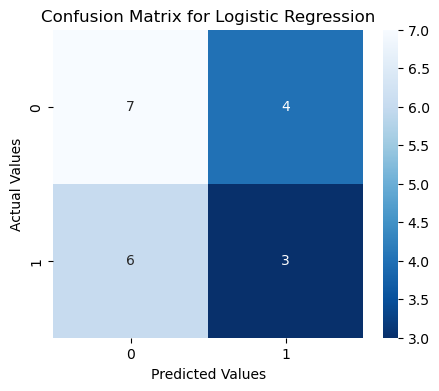

In [ ]:
log_reg = LogisticRegression(solver='liblinear')
log_reg_acc, log_reg_auc, log_reg_cm = evaluate_model(log_reg, "Logistic Regression")

Decision Tree

Training Decision Tree...
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.53      0.82      0.64        11
           1       0.33      0.11      0.17         9

    accuracy                           0.50        20
   macro avg       0.43      0.46      0.40        20
weighted avg       0.44      0.50      0.43        20




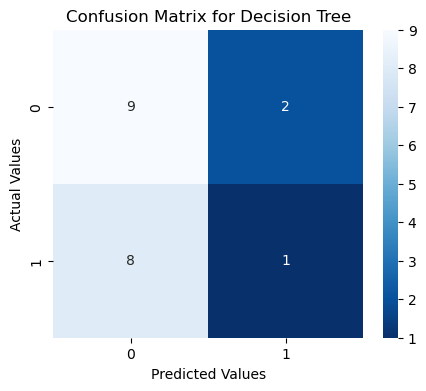

In [22]:
dt = DecisionTreeClassifier()
dt_acc, dt_auc, dt_cm = evaluate_model(dt, "Decision Tree")

Naive Bayes


Training Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.45      0.45      0.45        11
           1       0.33      0.33      0.33         9

    accuracy                           0.40        20
   macro avg       0.39      0.39      0.39        20
weighted avg       0.40      0.40      0.40        20




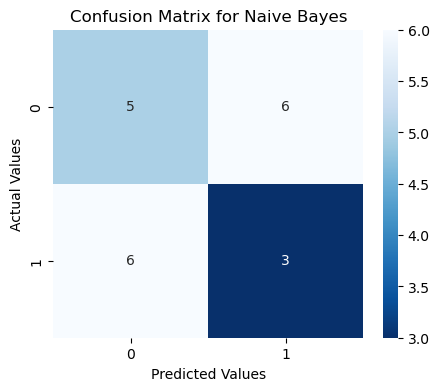

In [23]:
nb = GaussianNB()
nb_acc, nb_auc, nb_cm = evaluate_model(nb, "Naive Bayes")

K Nearest Neighbours

Training KNN...
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.40      0.22      0.29         9

    accuracy                           0.50        20
   macro avg       0.47      0.47      0.45        20
weighted avg       0.47      0.50      0.47        20




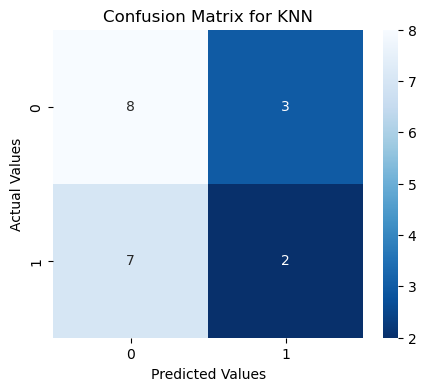

In [24]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', n_jobs=-1)
knn_acc, knn_auc, knn_cm = evaluate_model(knn, "KNN")

SVM

Training SVM...
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20




c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\anaconda3\envs\is217_env\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


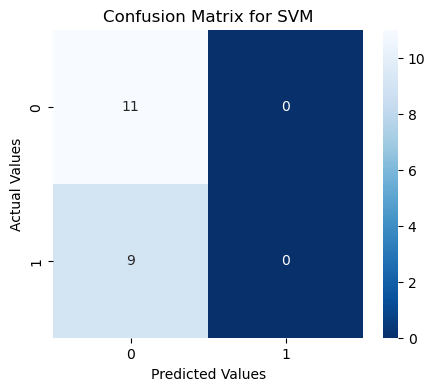

In [25]:
svm = SVC(probability=True)
svm_acc, svm_auc, svm_cm = evaluate_model(svm, "SVM")

Random Forrest

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.53      0.91      0.67        11
           1       0.00      0.00      0.00         9

    accuracy                           0.50        20
   macro avg       0.26      0.45      0.33        20
weighted avg       0.29      0.50      0.37        20




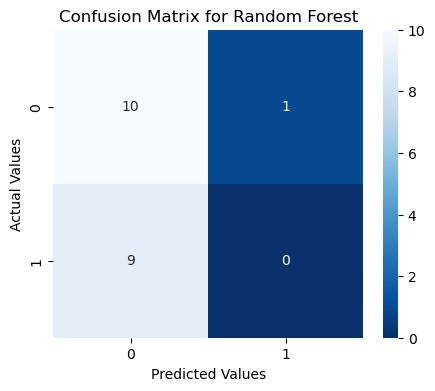

In [26]:
rf = RandomForestClassifier()
rf_acc, rf_auc, rf_cm = evaluate_model(rf, "Random Forest")

In [28]:
print("\nSummary of Results:")
models = ["Logistic Regression", "SVM", "KNN", "Decision Tree", "Random Forest", "Naive Bayes"]
accuracies = [log_reg_acc, svm_acc, knn_acc, dt_acc, rf_acc, nb_acc]
auc_scores = [log_reg_auc, svm_auc, knn_auc, dt_auc, rf_auc, nb_auc]
confusion_matrices = [log_reg_cm, svm_cm, knn_cm, dt_cm, rf_cm, nb_cm]

results = {
    "Model": models,
    "Accuracy": accuracies,
    "AUC": auc_scores,
    "Confusion Matrix": confusion_matrices
}

# Create the DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)


Summary of Results:
                 Model  Accuracy   AUC   Confusion Matrix
0  Logistic Regression      0.50  0.53   [[7, 4], [6, 3]]
1                  SVM      0.55  0.42  [[11, 0], [9, 0]]
2                  KNN      0.50  0.60   [[8, 3], [7, 2]]
3        Decision Tree      0.50  0.46   [[9, 2], [8, 1]]
4        Random Forest      0.50  0.30  [[10, 1], [9, 0]]
5          Naive Bayes      0.40  0.39   [[5, 6], [6, 3]]
